In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import statsmodels.api as sm
import statsmodels.formula.api as smf
from saturation.utils import *

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.api import add_constant

In [3]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "40g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

25/02/16 16:58:15 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
25/02/16 16:58:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/16 16:58:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/16 16:58:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [16]:
base_path = "/data/saturation/thesis_run_20250213/"

colors = ["blue", "black", "r", "orange", "g"]
line_styles = ["-"]
font_size = 24
dpi = 400

configs_df = create_configs_df(
    read_configs(
        base_path,
        spark,
        completed_only=False
    )
)
configs_pdf = configs_df.toPandas()

configs_pdf = configs_pdf[~configs_pdf.simulation_id.isna()].copy()
configs_pdf["rim_erasure_exponent"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("exponent", -1))
configs_pdf["rim_erasure_radius_ratio"] = configs_pdf.rim_erasure_method.apply(lambda x: x.get("ratio", -1))
configs_pdf["nstop"] = configs_pdf.stop_condition.apply(lambda x: x.get("ntot", -1))

In [17]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    configs_dict.update(read_config(Path(config_file))["run_configurations"])

In [18]:
configs_pdf[configs_pdf.slope.between(-4.6, -4.4)]

,mrp,rim_erasure_method,rmin,rmult,simulation_id,slope,stop_condition,study_region_padding,study_region_size,rim_erasure_exponent,rim_erasure_radius_ratio,nstop
8,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.1}",0.37,1.0,18,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.1,3.0,-1
22,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.4}",0.37,1.0,63,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.4,3.0,-1
63,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.3}",0.37,1.0,48,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.3,3.0,-1
77,0.5,"{'name': None, 'ratio': 1000000.0, 'exponent':...",1.00,1.0,3,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,1.0,1000000.0,-1
88,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 1.0}",1.00,1.0,1,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,1.0,3.0,-1
104,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 1.0}",0.37,1.0,153,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,1.0,3.0,-1
105,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.9}",0.37,1.0,138,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.9,3.0,-1
112,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.7}",0.37,1.0,108,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.7,3.0,-1
128,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.2}",0.37,1.0,33,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.2,3.0,-1
143,0.5,"{'name': None, 'ratio': 3.0, 'exponent': 0.5}",0.37,1.0,78,-4.5,"{'name': 'nstat', 'nstat': '2500000'}",250,2000,0.5,3.0,-1


In [24]:
df = get_statistics_with_lifespans_for_simulations(
    simulation_ids=[1],
    base_path=base_path,
    configs_df=configs_df,
    spark=spark,
    n_samples_per_sim=1000000
)
df

,x,y,radius,simulation_id,nstat,nobs,areal_density,slope,mrp,rmult,rim_erasure_method_name,rim_erasure_radius_ratio,rim_erasure_exponent,lifespan
0,1750.704989,1094.270181,3.766048,1,1,1,0.000011,-4.5,0.5,1.0,NaN,3.0,1.0,1352005.0
1,1755.441322,2108.775008,3.256511,1,2,2,0.000019,-4.5,0.5,1.0,NaN,3.0,1.0,1198054.0
2,1286.380209,1544.088832,4.921868,1,3,3,0.000039,-4.5,0.5,1.0,NaN,3.0,1.0,1465794.0
3,2245.076938,390.710247,4.054762,1,4,4,0.000051,-4.5,0.5,1.0,NaN,3.0,1.0,714994.0
4,485.460812,1201.734623,3.315666,1,5,5,0.000060,-4.5,0.5,1.0,NaN,3.0,1.0,616108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1462.874364,2180.803973,3.198265,1,1874995,8182,0.275075,-4.5,0.5,1.0,NaN,3.0,1.0,813476.0
999996,835.951279,716.840515,3.430948,1,1874996,8182,0.275073,-4.5,0.5,1.0,NaN,3.0,1.0,769103.0
999997,1482.735866,1232.655543,6.208613,1,1874997,8183,0.275103,-4.5,0.5,1.0,NaN,3.0,1.0,9092982.0
999998,1246.483387,1035.265594,3.943513,1,1874998,8183,0.275099,-4.5,0.5,1.0,NaN,3.0,1.0,791606.0


In [29]:
df["s"] = df.radius * 2 * np.pi

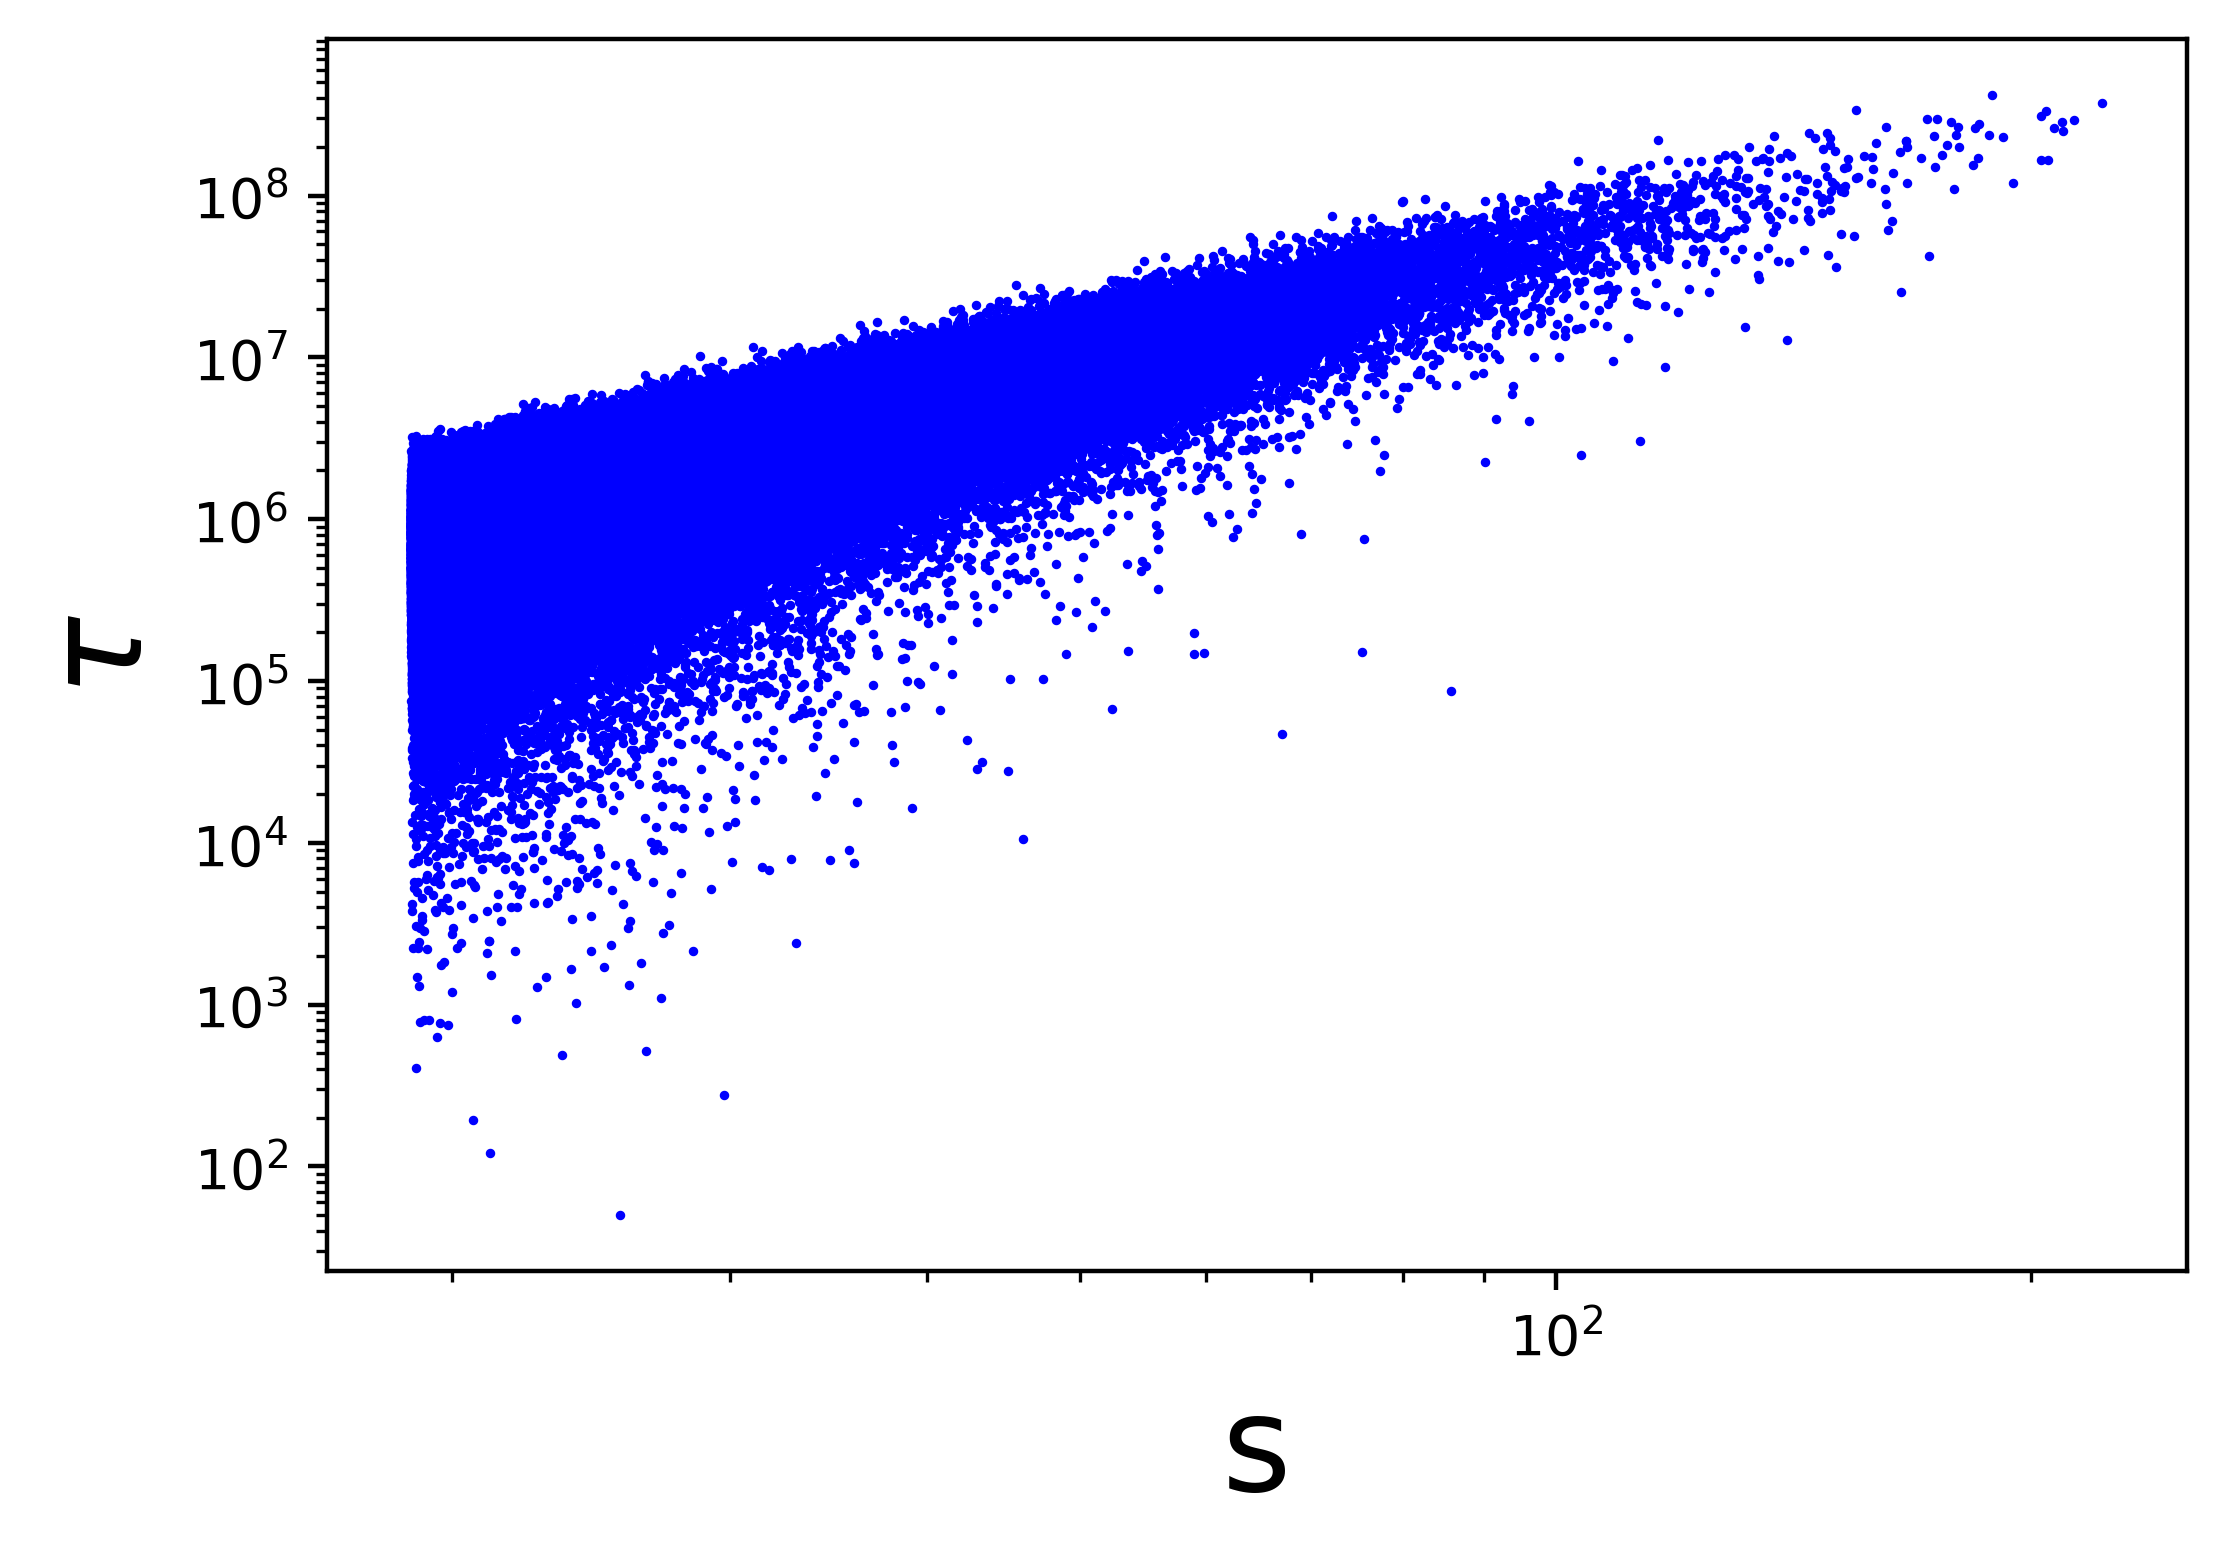

In [30]:
plt.figure(figsize=(6, 4), dpi=dpi)

# Sampled scatterplot
plt.scatter(
    df.s,
    df.lifespan,
    c="blue",
    s=.5,
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("s", fontsize=font_size)
plt.ylabel("$\\tau$", fontsize=font_size)

plt.savefig(f"figures/example_lifetimes_scatter.png", bbox_inches="tight")
plt.show()

In [31]:
model = smf.negativebinomial(data=df, formula="lifespan ~ 1 + np.log(s)").fit(maxiter=1000, method="BFGS", cov_type="HC0")
print(model.summary())

Optimization terminated successfully.
         Current function value: 14.738838
         Iterations: 14
         Function evaluations: 18
         Gradient evaluations: 18
                     NegativeBinomial Regression Results                      
Dep. Variable:               lifespan   No. Observations:               999976
Model:               NegativeBinomial   Df Residuals:                   999974
Method:                           MLE   Df Model:                            1
Date:                Sun, 16 Feb 2025   Pseudo R-squ.:                 0.03938
Time:                        17:13:10   Log-Likelihood:            -1.4738e+07
converged:                       True   LL-Null:                   -1.5343e+07
Covariance Type:                  HC0   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.2472      0.006    9

In [32]:
# Dispersion statistic
np.sum(model.resid_pearson**2) / model.df_resid

0.9173842866139518